# DATASCI 420: Lesson 08 Assignment 
Author: Ajai Shukla
Instructions

It is recommended you complete the lab exercises for this lesson before beginning the assignment.

For this assignment you will start from the perceptron neural network notebook (Simple Perceptron Neural Network.ipynb) and modify the python code to make it into a multi-layer neural network classifier. To test your system, use the RedWhiteWine.csv file with the goal of building a red or white wine classifier. Use all the features in the dataset, allowing the network to decide how to build the internal weighting system. To review the data attributes, download the L08_WineQuality.pdf.  Perform each of the following tasks and answer the related questions:

    Use the provided RedWhiteWine.csv file. Include ALL the features with “Class” being your output vector
    Use the provided Simple Perceptron Neural Network notebook to develop a multi-layer feed-forward/backpropagation neural network
    Be able to adjust the following between experiments:
        Learning Rate
        Number of epochs
        Depth of architecture—number of hidden layers between the input and output layers
        Number of nodes in a hidden layer—width of the hidden layers
        (optional) Momentum
    Determine what the best neural network structure and hyperparameter settings results in the best predictive capability


In [12]:
!pip install  missingno

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [13]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# Import Pandas
import pandas as pd

# Import Numpy
import numpy as np

# Import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm
from sklearn.model_selection import cross_validate

# Import Tensorflow
import tensorflow as tf

# Import scipy
from scipy import stats as st

# Import warnings
import warnings 
warnings.filterwarnings('ignore')

# Import pyplot from matplotlib as plt
import matplotlib.pyplot as plt
%matplotlib inline

# Import Missing Nap
import missingno as msno

# Import Seaborn
import seaborn as sns

# Import Bokeh
from bokeh.plotting import figure, output_file, show
from bokeh.palettes import d3
from bokeh.io import output_notebook
from bokeh.models import Legend
output_notebook()

Loading BokehJS ...

Load and prepare the data

A critical step in working with neural networks is preparing the data correctly. Variables on different scales make it difficult for the network to efficiently learn the correct weights.

In [18]:
# Load the data
wine_red_df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv", sep = ";")
wine_white_df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv", sep = ";")

Let see whether we have the data or not by viewing the top 5 samples in the red and white dataset.

In [19]:
# View first five samples of the Red wine data
wine_red_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [20]:
# View first five samples of the White wine data
wine_white_df.head()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


Thus we see that we have our data being loaded succesfully. But how many samples and variables we have in our dataset.? Ok lets take a time to answer that question.

In [21]:
# Dimension of the data
print("The Red wine dataset has", wine_red_df.shape[0], "number of observations and", 
      wine_red_df.shape[1], "variables")
print("The White wine dataset has", wine_white_df.shape[0], "number of observations and",
      wine_white_df.shape[1], "variables")

The Red wine dataset has 1599 number of observations and 12 variables
The White wine dataset has 4898 number of observations and 12 variables


Thus we have seen dimensions of the data, both the dataset has same number of variables but white wine has almost thrice the amount of observations then the red wine dataset. Each wine sample (row) has the following characteristics (columns):

    Fixed acidity
    Volatile acidity
    Citric acid
    Residual sugar
    Chlorides
    Free sulfur dioxide
    Total sulfur dioxide
    Density
    pH
    Sulphates
    Alcohol
    Quality (score between 0 and 10)

Data Preprocessing

Now that we have loaded the dateset, we will need to process it before we can do any analysis. Oftentimes, data can be quite messy, especially if it hasn’t been well-maintained. You’ll see errors that will corrupt your analysis: values set to null though they really are zero, duplicate values, and missing values. This whole process is called Data Processing. Data processing is, generally, the collection and manipulation of items of data to produce meaningful information. In this sense it can be considered a subset of information processing, the change (processing) of information in any manner detectable by an observer.

Let us first check the data for missing values and latter when buliding the model we will be discussing other forms of data preprocessing.

Thus we kind of see that there is no missing data in the dataset using missing map. However just confirm that we hardly have no missing values, we will run a small sanity check over the dataset.

In [33]:
# Compute the percentage of missing value in the data
def missing_percentage(data1, data2, col_name = "Missing value (%)"):
    # Calculating the missing percentage
    missing_df1 = pd.DataFrame(data1.isnull().sum() /len(data1)*100, columns = [col_name])
    missing_df2 = pd.DataFrame(data2.isnull().sum() /len(data2)*100, columns = [col_name])
    # Forming the output dataframe
    missing_df = pd.DataFrame({'Red Wine': missing_df1.iloc[:, 0], 'White wine': missing_df2.iloc[:, 0]})
    return missing_df

missing_percentage(wine_red_df, wine_white_df)

,Red Wine,White wine
fixed acidity,0.0,0.0
volatile acidity,0.0,0.0
citric acid,0.0,0.0
residual sugar,0.0,0.0
chlorides,0.0,0.0
free sulfur dioxide,0.0,0.0
total sulfur dioxide,0.0,0.0
density,0.0,0.0
pH,0.0,0.0
sulphates,0.0,0.0


Above table in additon to the missing map clearly shows that we have the data intact 100% and there is no missing data in the our dataset.


Exploratory Data Analysis

As we have checked our data for the missing values, let shift our focus in understanding the data in much better way. Ww will be using visualization in order to do Exploratory Data Analysis(EDA). EDA is an approach for data analysis that employs a variety of techniques mostly graphical to

    Maximize insight into a data set
    Uncover underlying structure
    Extract important variables
    Detect outliers and anomalies
    Test underlying assumptions
    Develop parsimonious models
    Determine optimal factor settings

Lets gets started!!!!!!

First up lets check how the quality of wine is distributed accross. I am using barplot to visualize this because its the right choice to visualize any categoical data.


In [34]:
def custom_style(title, xlab, ylab, width = 800, height = 600):
    # Create the plot
    p = figure(plot_width = width, plot_height = height, title = title, x_axis_label = xlab, y_axis_label = ylab)
    # Custom changes
    p.title.text_font_size = "20pt"
    p.title.align = "center"
    p.xaxis.axis_label_text_font_size = "20pt"
    p.yaxis.axis_label_text_font_size = "20pt"
    return p

def custom_barplot(data, width = 800, height = 600, color = "#3687cc", title = "Barplot", xlab = "Category",
                   ylab = "Counts"):
    # Get the quantity and its count from the dataset
    counts = data.value_counts()
    # Get the custom style formsts
    p = custom_style(width = width, height = height, title = title, xlab = xlab, ylab = ylab)
    
    # Call the vertical bar
    p.vbar(x = counts.index, top = counts.values, width = 0.5, bottom = 0,  color = color)
    
    # Show the plot
    return show(p)

custom_barplot(wine_red_df.quality, title = "Red Wine Quality", xlab = "Quality Level of wine (0 to 10 scale)", 
               ylab = "Counts")

In [35]:
custom_barplot(wine_white_df.quality, title = "White Wine Quality", xlab = "Quality Level of wine (0 to 10 scale)", 
               ylab = "Counts")

According to the data description, quanity is a score between 0 to 10. But we can see that red and white wine doesn't have any values in the low and high extreme ends of the scale 0 to 10. In addition we can also see that the quality rating are kind of normally distributed with large ditribution in the center of the scale around 5 and 6 and flatenning out in the ends. The normal distibution of the quality is true because there is will be few top wines in the market and then followed by bunch of medium quality wines and then the lower ends.

In [36]:
# Quanlity and Alcohol
def scatter_plot(data, x, y, title = "Scatter Plot", xlab = "X-axis", ylab ="Y-axis"):
    p = custom_style(title = title, xlab = xlab, ylab = ylab)
    data = wine_red_df
    grouped_data = [data.loc[data[x] == i, [x, y]] 
                    for i in np.unique(data[x])]
    color_list = d3['Category10'][len(grouped_data)]
    for i in range(len(grouped_data)):
        p.circle(grouped_data[i][x].tolist(), grouped_data[i][y].tolist(), size = 10, color = color_list[i])
    show(p)
    
scatter_plot(wine_red_df, x = "quality", y = "alcohol", title = "Red Wine's Quality vs Alcohol", 
             xlab = "Quality Level of wine (0 to 10 scale)", ylab = "Alcohol Content")

In [37]:
scatter_plot(wine_white_df, x = "quality", y = "alcohol", title = "White Wine's Quality vs Alcohol", 
             xlab = "Quality Level of wine (0 to 10 scale)", ylab = "Alcohol Content")

When we look at the red and white wine's alcohol content we can see some increasing trend from the lower quality rating to the high quality rating. This shows that quality is depend on the alcohol content in the wine. But how much does the quality depends on the Alcohol content. In order to answer that question, we will try to address the all the rlation between the the variables in our dataset using correlation and heatmaps.

Correlation

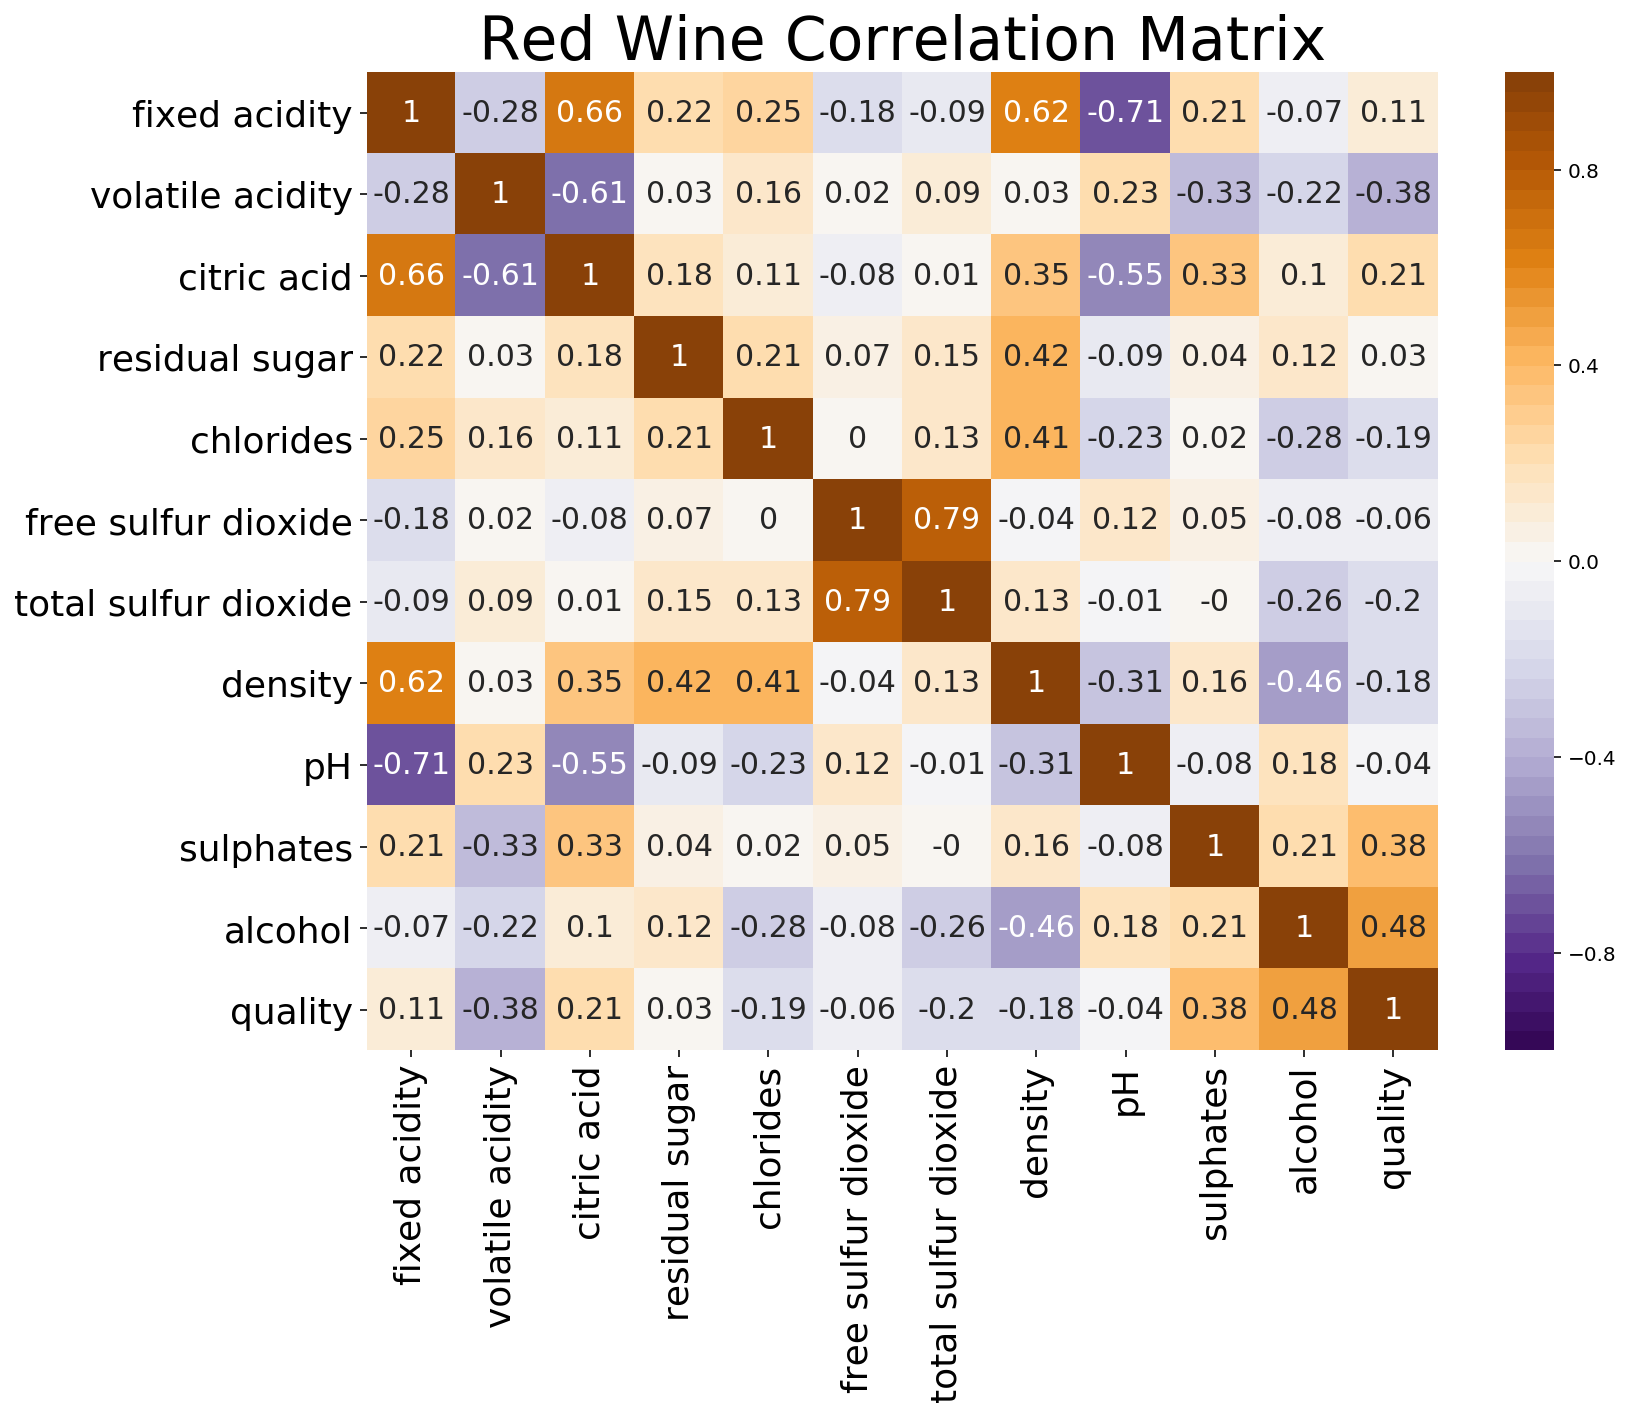

In [39]:
def confusion_matrix_plot(data, title = "Red Wine Correlation Matrix", height = 9, width = 12):
    # Get the confusion matrix
    conf_mat = round(data.corr(method ="spearman"), 2)
    # Create the heatmap
    plt.figure(figsize = (width, height))
    ax = sns.heatmap(conf_mat, annot=True, annot_kws={"size": 15}, cmap = sns.color_palette("PuOr_r", 50), 
                     vmin = -1, vmax = 1)
    # Customize the style of the heatmap
    # Set the title, it's font size and position
    ax.axes.set_title(title, fontsize = 30)
    ax.title.set_position([.5, 1.03])
    ax.set_xticklabels(labels = conf_mat.index, fontsize = 18)
    ax.set_yticklabels(labels = conf_mat.index, fontsize = 18)
    # Show the plot
    plt.show()
    
# Call the confusion matrix function
confusion_matrix_plot(wine_red_df, title = "Red Wine Correlation Matrix")

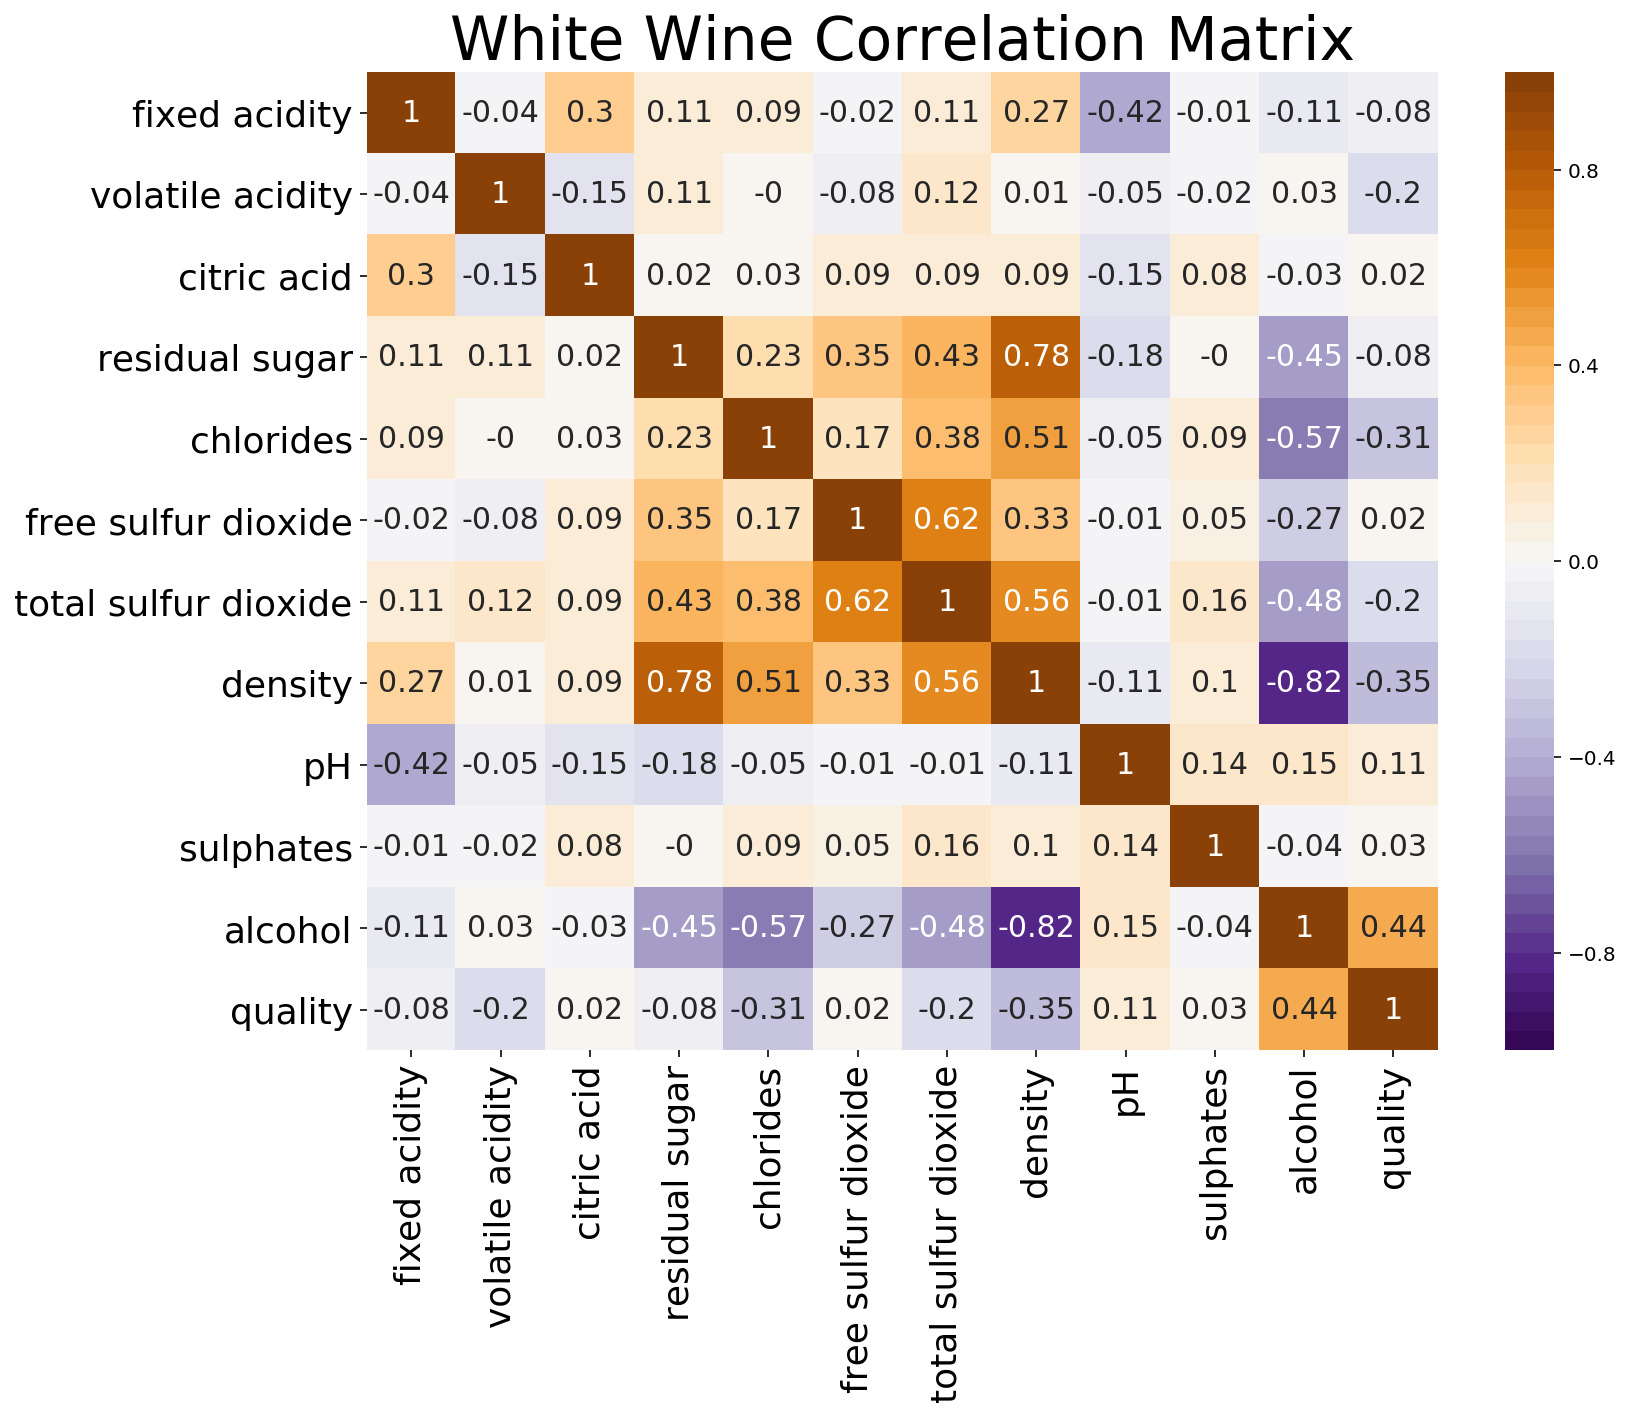

In [40]:
confusion_matrix_plot(wine_white_df, title = "White Wine Correlation Matrix")

From the above white wine heatmap, we have the following inferences

    We see that low density contents are high on alcohol content
    Sugar content in the wine might represents the wine density
    Just like red wine, here also total and free sulfur dioxide are related together

Now that we have seen much about the predictors lets see the responding varaible quality and how it is related to the predictors. We see the quality is more depend on the folowwing from both red and white wines
Positive relation (Increase in this will increase the quality)

    Alcohol
    Sulphates

Positive relation (Increase in this will decrease the quality)

    Density
    Volatile acidity
    Chlorides

This is interesting. We can suggest the manufactures this so that they will be benefit by increasing the wine quality. About the usage of features to use in the model, this heatmaps and correlation helps us decide that

    Free sulfur dioxide is not much related to quality and removing it from the predictora helps us do the dimensionality reduction and also adds weightage to other predictora most precisely it will add to total sulfur dioxide content.

However we wont be removing this feature as of now because this dataset is not that huge enough. With the present days GPUs and CPUs computation this sized dataset is not going to that difficult enough. So we will be using all the feature for our model predictions.

Other than that we will use all other predictors in our model.


# Skewness

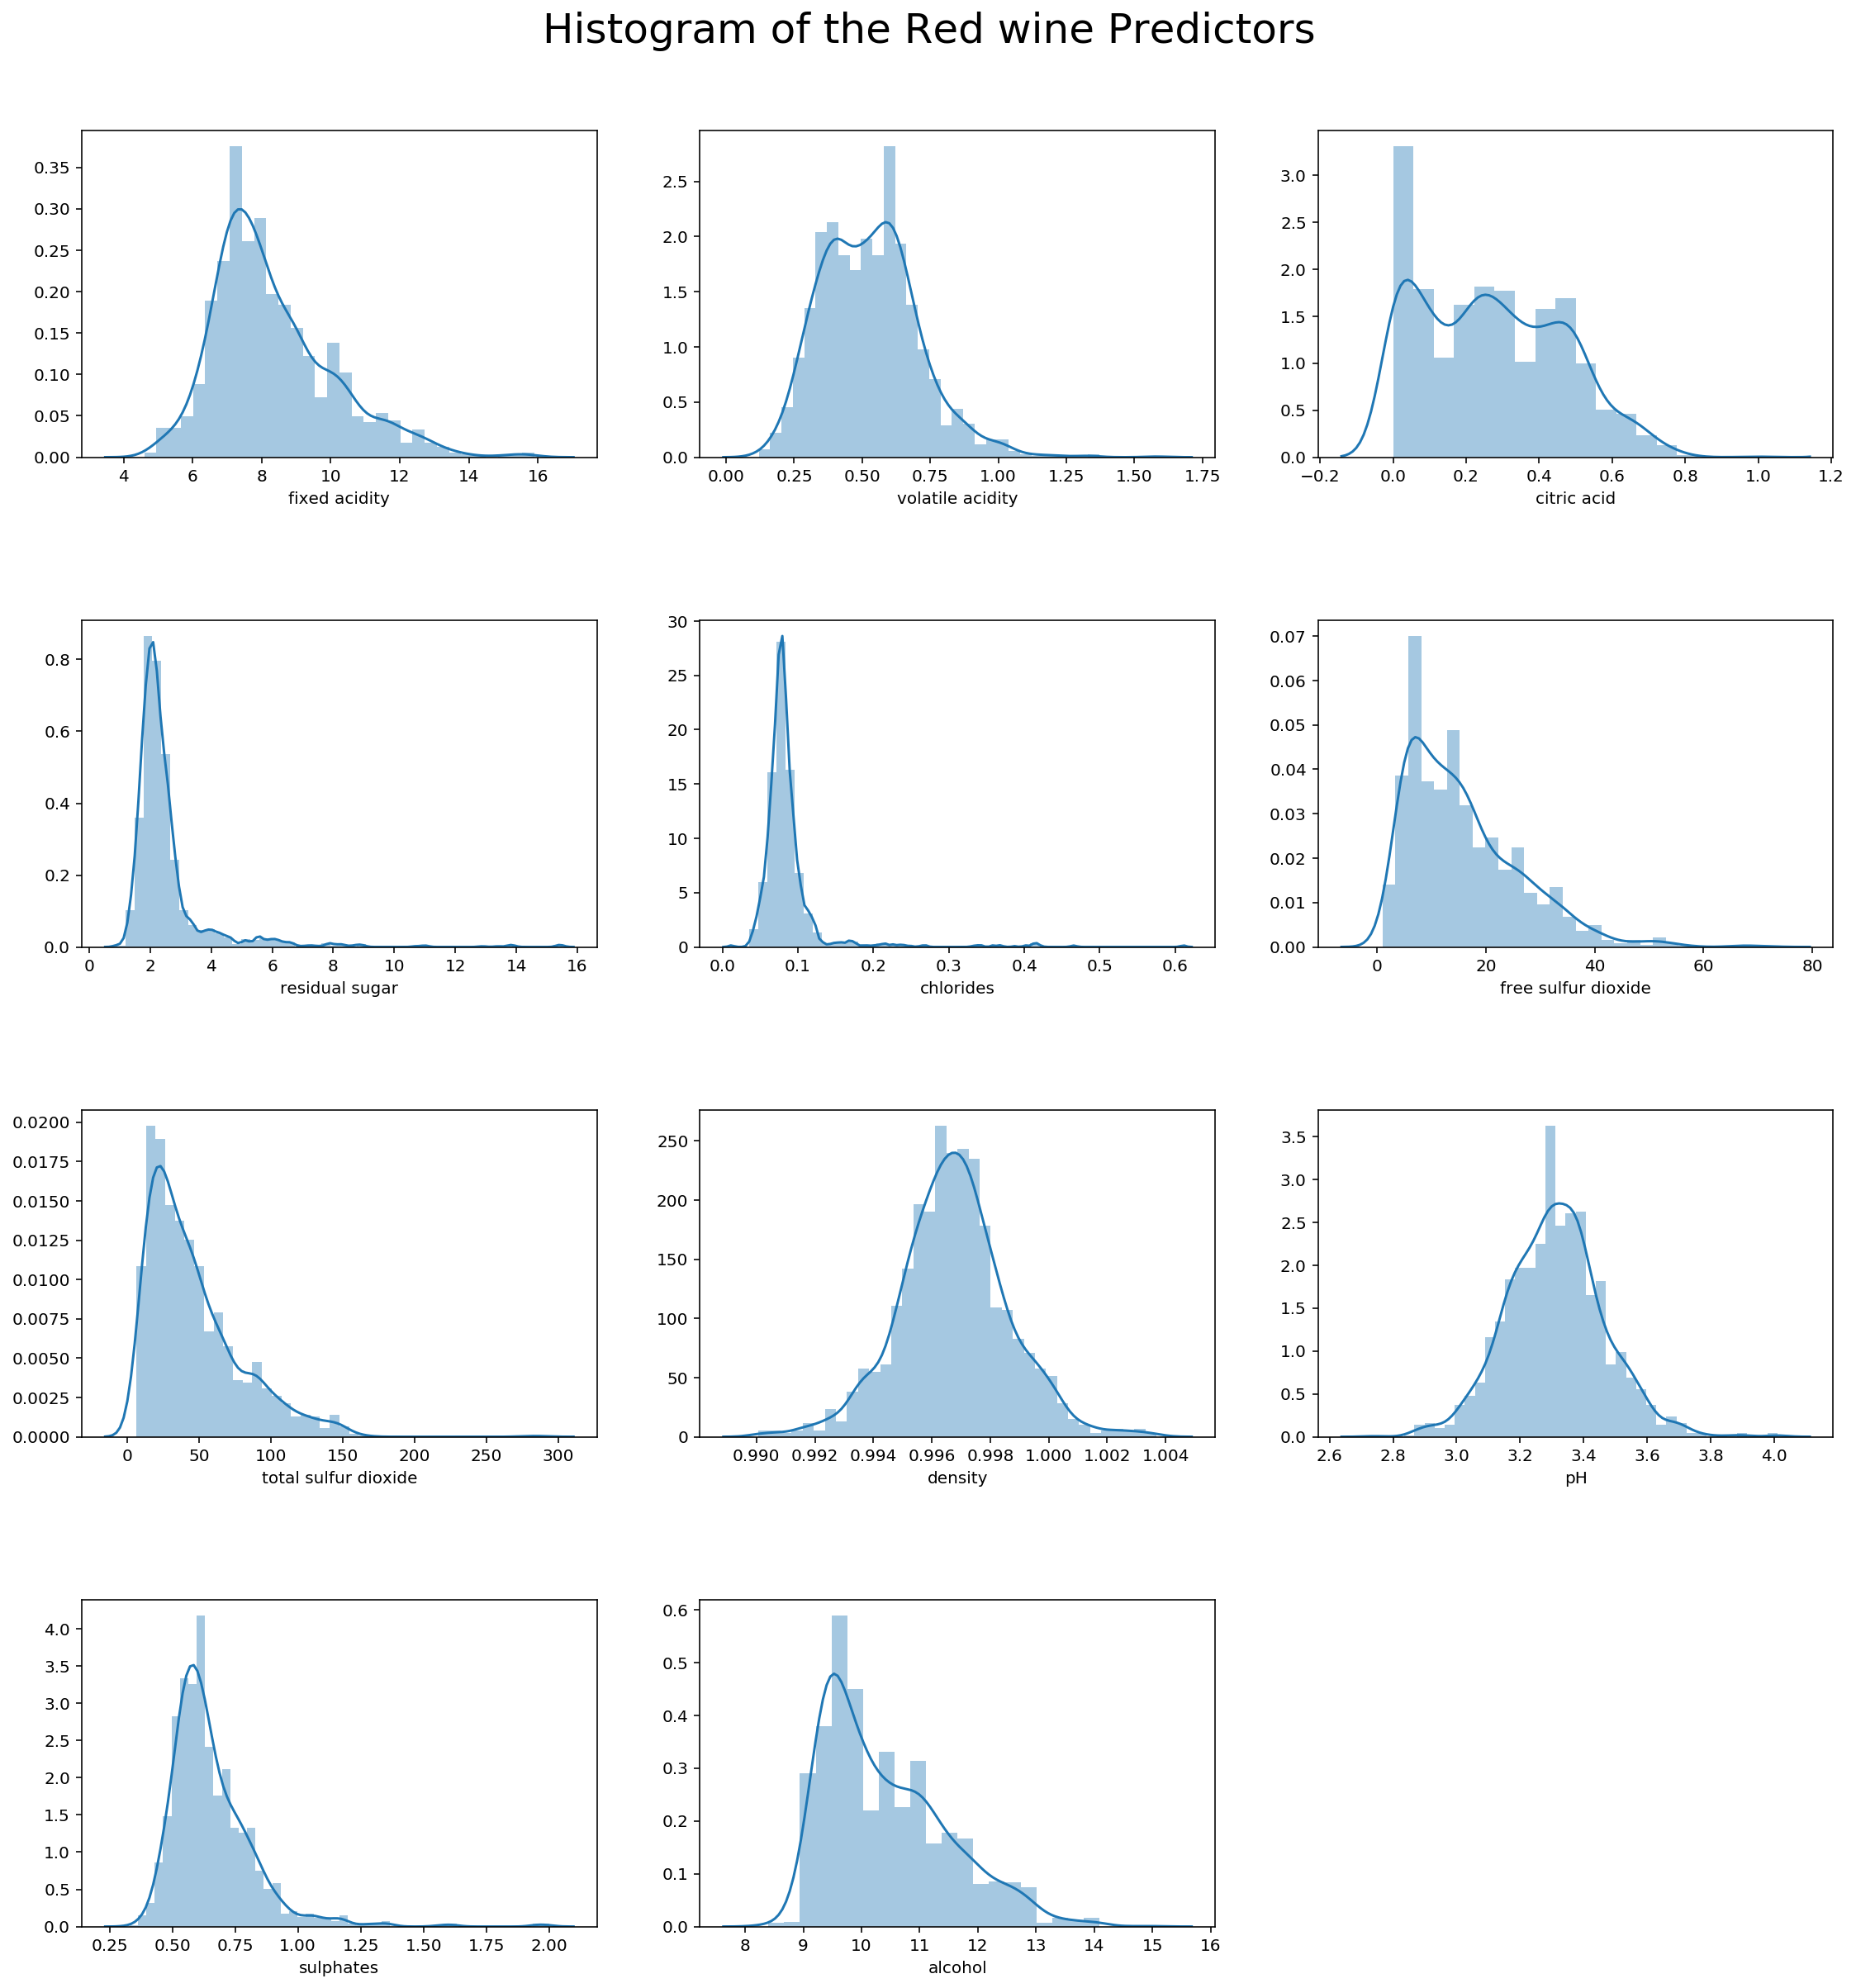

In [43]:
def subplot_hist(data, row = 4, column = 3, title = "Subplots", height = 20, width = 19):
    # Create a figure instance, and the two subplots
    fig = plt.figure(figsize = (width, height))
    fig.suptitle(title, fontsize=25, y = 0.93)
    # Run loop over the all the variables
    for i in range(data.shape[1]):
        # Create the axis line
        ax = fig.add_subplot(row, column, i + 1)
        fig.subplots_adjust(hspace = .5)
        # Create histogram for each variable
        sns.distplot(wine_red_df.iloc[:, i], ax=ax)
    # Show the plot
    plt.show()
    
subplot_hist(wine_red_df.iloc[:, :-1], row = 4, column = 3, title = "Histogram of the Red wine Predictors")

Before talking abour this let us also visualize the white wine dataset predictors also.

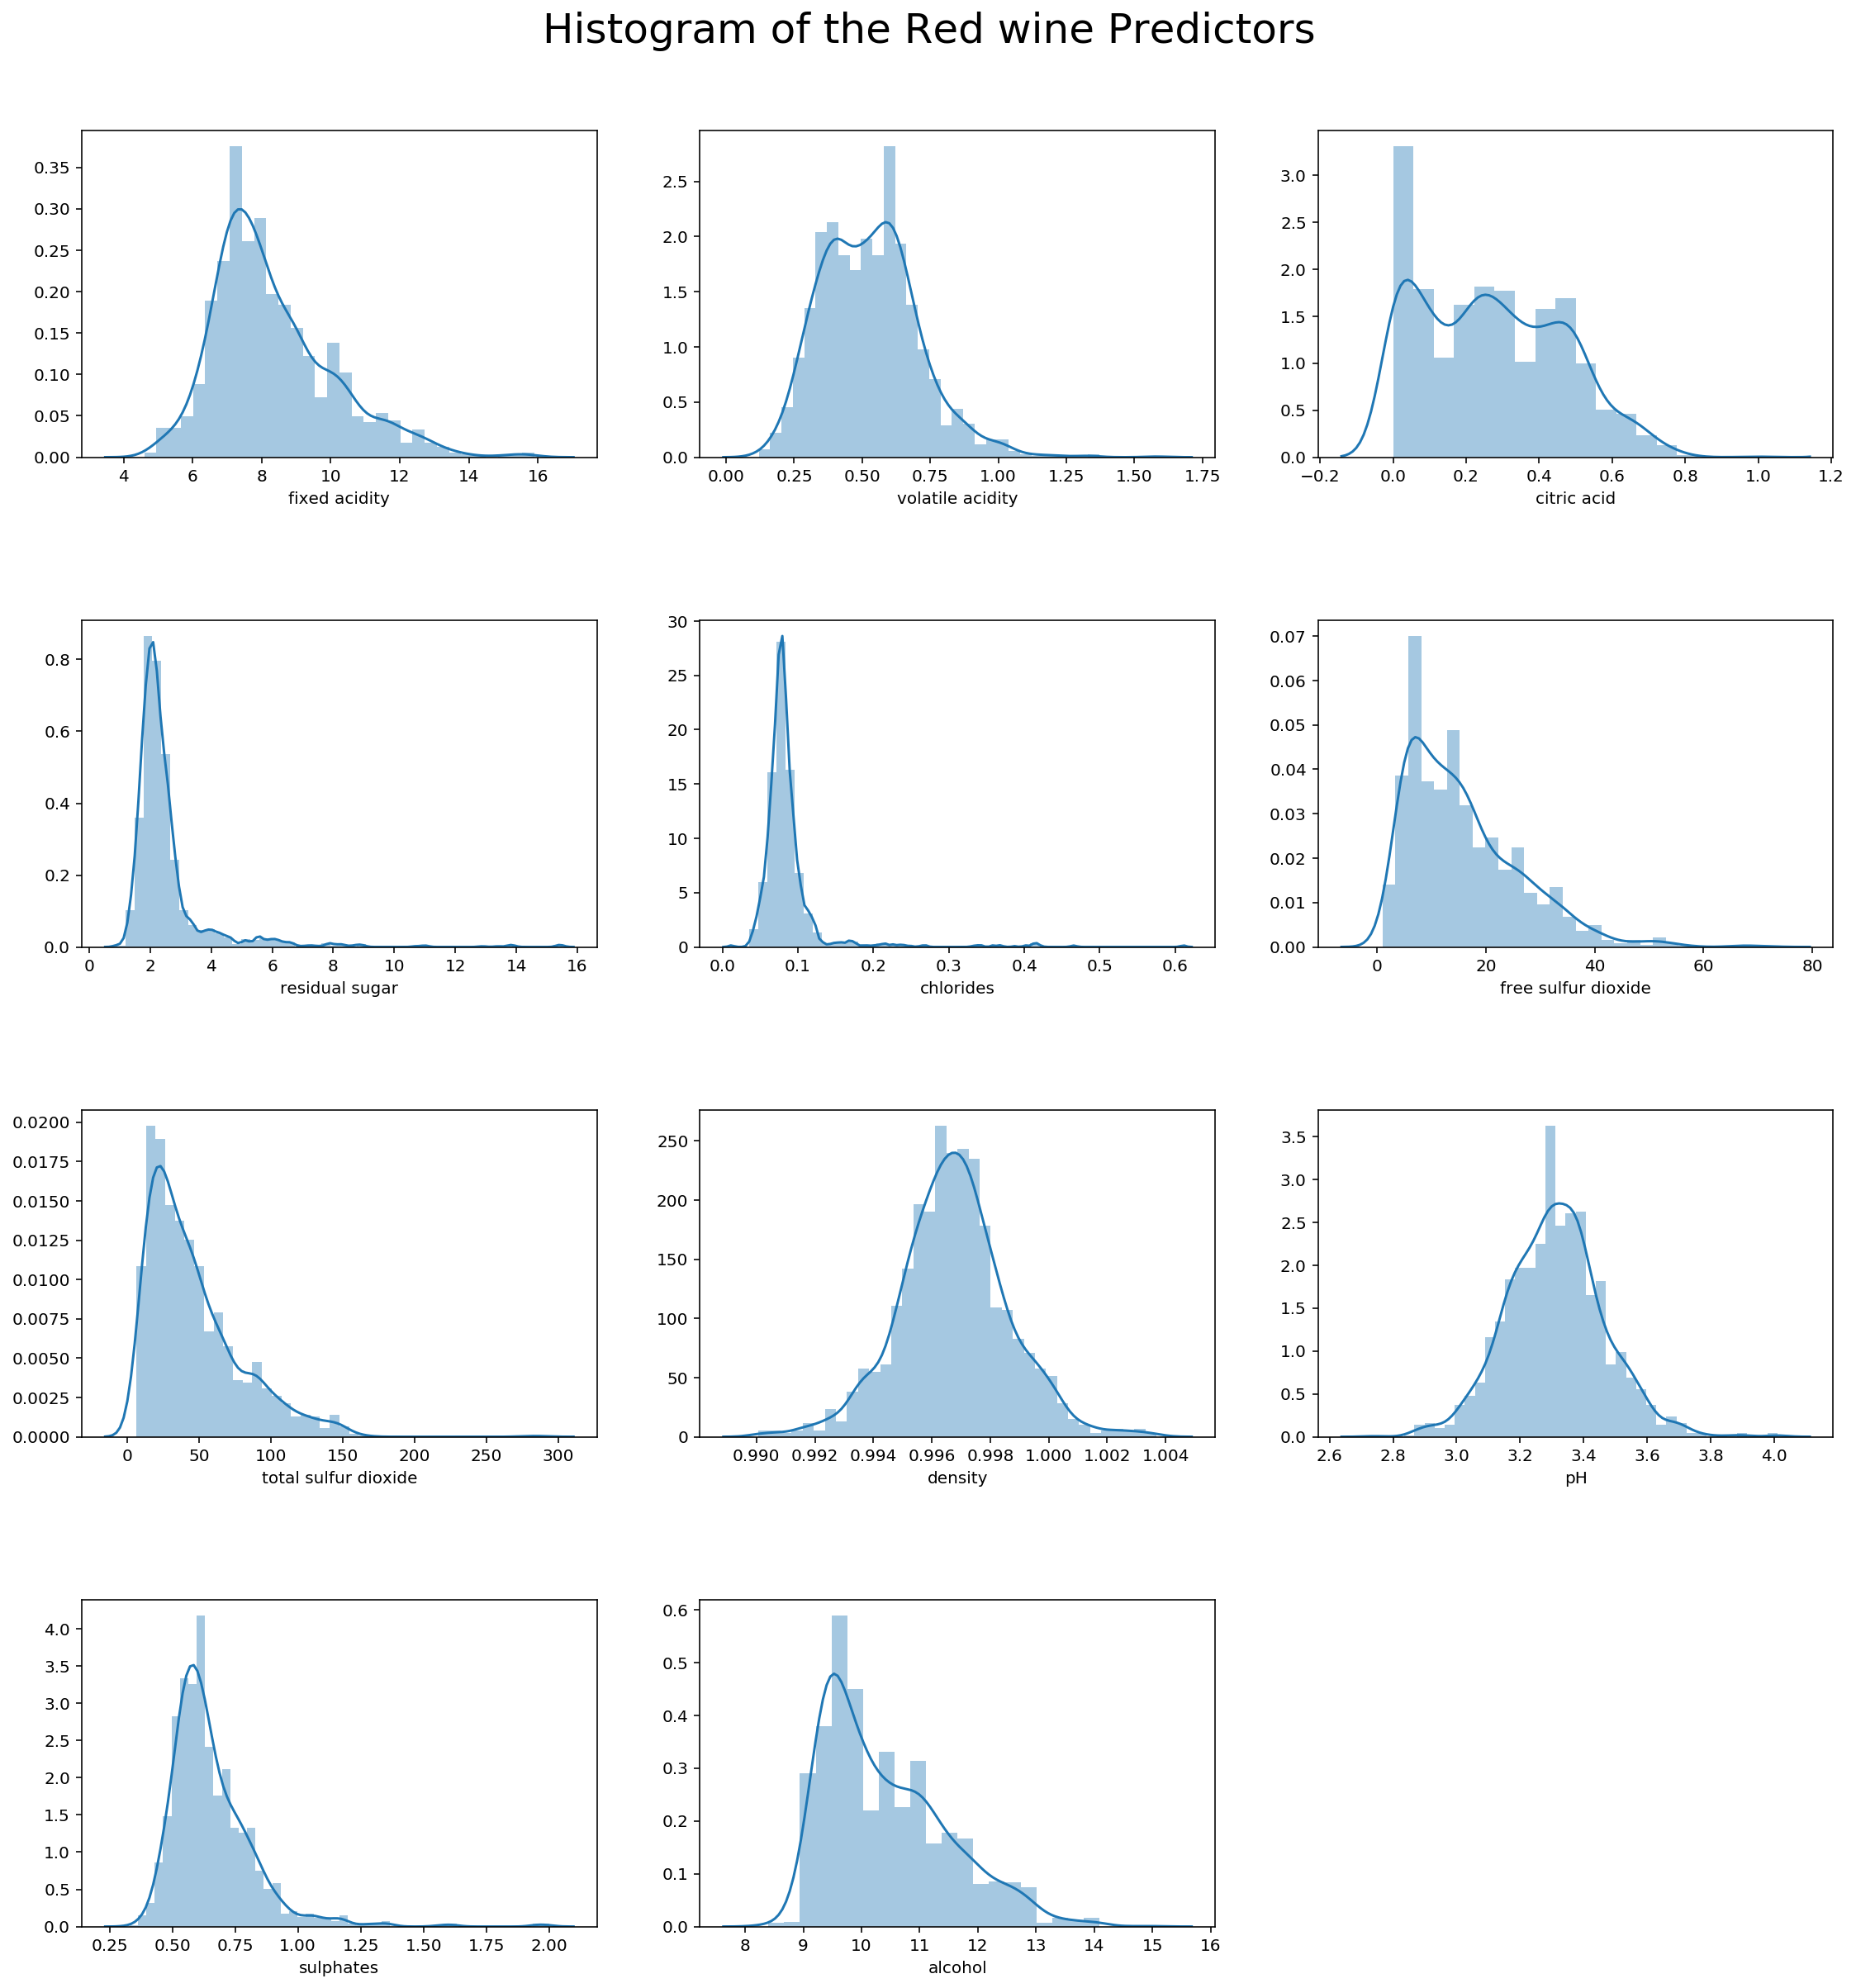

In [44]:
subplot_hist(wine_white_df.iloc[:, :-1], row = 4, column = 3, title = "Histogram of the Red wine Predictors")

Now on seeing the distributions of the predictors of the both the dataset, we see some of the predictora are skewed. This is not good for modeling thus, we will do a boxcox transformation in order to remove the skewness in the dataset.

But when doing a boxcox transformation I found out that the citric acid predictors has some observation to be zero. To handle this we will just add 0.1 to the column so that we are not distorating the distribution and at the same time we can perform boxcox trainsfomation


In [45]:
wine_red_df[["citric acid"]] += 0.1
wine_white_df[["citric acid"]] += 0.1

Now that we have moved the whole distribution to the right a bit for citric acid we can do the boxcox transformation. But before that lets check skewness value of the predictors.

In [46]:
# Computing the skewness into dataFrame
def skewness_check(data):
    # Find the skewness in the dataset
    skew_value = list(st.skew(data))
    skew_string = []
    # Looping through the skew value to find the Skew category
    for skew in skew_value:
        if skew >= -.5 and skew <= .5:
            skew_string.append("Light Skewed")
        elif skew <= -.5 and skew >= -1 and skew <= .5 and skew >= 1:
            skew_string.append("Moderately Skewed")
        else:
            skew_string.append("Heavily Skewed")
    # Ctreating data frame
    skew_df = pd.DataFrame({'Column': data.columns, 'Skewness': skew_value, 'Skew Category': skew_string})
    return skew_df

# Skewness for Red Wine
skewness_check(wine_red_df.iloc[:, :-1])

,Column,Skewness,Skew Category
0,fixed acidity,0.981829,Heavily Skewed
1,volatile acidity,0.670962,Heavily Skewed
2,citric acid,0.318039,Light Skewed
3,residual sugar,4.536395,Heavily Skewed
4,chlorides,5.675017,Heavily Skewed
5,free sulfur dioxide,1.249394,Heavily Skewed
6,total sulfur dioxide,1.514109,Heavily Skewed
7,density,0.071221,Light Skewed
8,pH,0.193502,Light Skewed
9,sulphates,2.426393,Heavily Skewed


Above we have the skewness table of red wine. It clearly understandable that most of the predictors are havily skewed. What about the white wine dataset? Lets see that.

In [47]:
# Skewness for White Wine
skewness_check(wine_white_df.iloc[:, :-1])

,Column,Skewness,Skew Category
0,fixed acidity,0.647553,Heavily Skewed
1,volatile acidity,1.576497,Heavily Skewed
2,citric acid,1.281528,Heavily Skewed
3,residual sugar,1.076764,Heavily Skewed
4,chlorides,5.021792,Heavily Skewed
5,free sulfur dioxide,1.406314,Heavily Skewed
6,total sulfur dioxide,0.390590,Light Skewed
7,density,0.977474,Heavily Skewed
8,pH,0.457642,Light Skewed
9,sulphates,0.976894,Heavily Skewed


It is the same scanario with white wine too. Here also we have lot of skewed values. So applying box =cox transformation should considerably helpw with removing the skewness.

In [48]:
# Boxcox Tranformation
def boxcox_trans(data):
    for i in range(data.shape[1]):
        data.iloc[:, i], _ = st.boxcox(data.iloc[:, i])
    return data

# Subset the predcitors
red_trans = wine_red_df.copy(deep = True)
red_trans.iloc[:, :-1] = boxcox_trans(red_trans.iloc[:, :-1])
skewness_check(red_trans.iloc[:, :-1])

,Column,Skewness,Skew Category
0,fixed acidity,0.000517,Light Skewed
1,volatile acidity,0.000595,Light Skewed
2,citric acid,-0.112744,Light Skewed
3,residual sugar,-0.095840,Light Skewed
4,chlorides,-0.499174,Light Skewed
5,free sulfur dioxide,-0.019759,Light Skewed
6,total sulfur dioxide,-0.008021,Light Skewed
7,density,-0.004737,Light Skewed
8,pH,-0.000300,Light Skewed
9,sulphates,-0.024756,Light Skewed


In [49]:
# Subset the predcitors
white_trans = wine_white_df.copy(deep = True)
white_trans.iloc[:, :-1] = boxcox_trans(white_trans.iloc[:, :-1])
skewness_check(white_trans.iloc[:, :-1])

,Column,Skewness,Skew Category
0,fixed acidity,-0.005864,Light Skewed
1,volatile acidity,-0.005001,Light Skewed
2,citric acid,0.110011,Light Skewed
3,residual sugar,-0.051901,Light Skewed
4,chlorides,-0.159103,Light Skewed
5,free sulfur dioxide,0.030898,Light Skewed
6,total sulfur dioxide,0.022700,Light Skewed
7,density,0.018593,Light Skewed
8,pH,-0.003674,Light Skewed
9,sulphates,-0.001163,Light Skewed


We can see that the skew category for all the predictors now is light skewed. Thus we can see that both red and white wine has been removed skewness by using boxcox transformation.
Outlers

After removing the skewness, do we have outliers in the datasst?. Let us check that. First we will try to visualize the data in the original form and then we will see the transformed data for both the dataset.


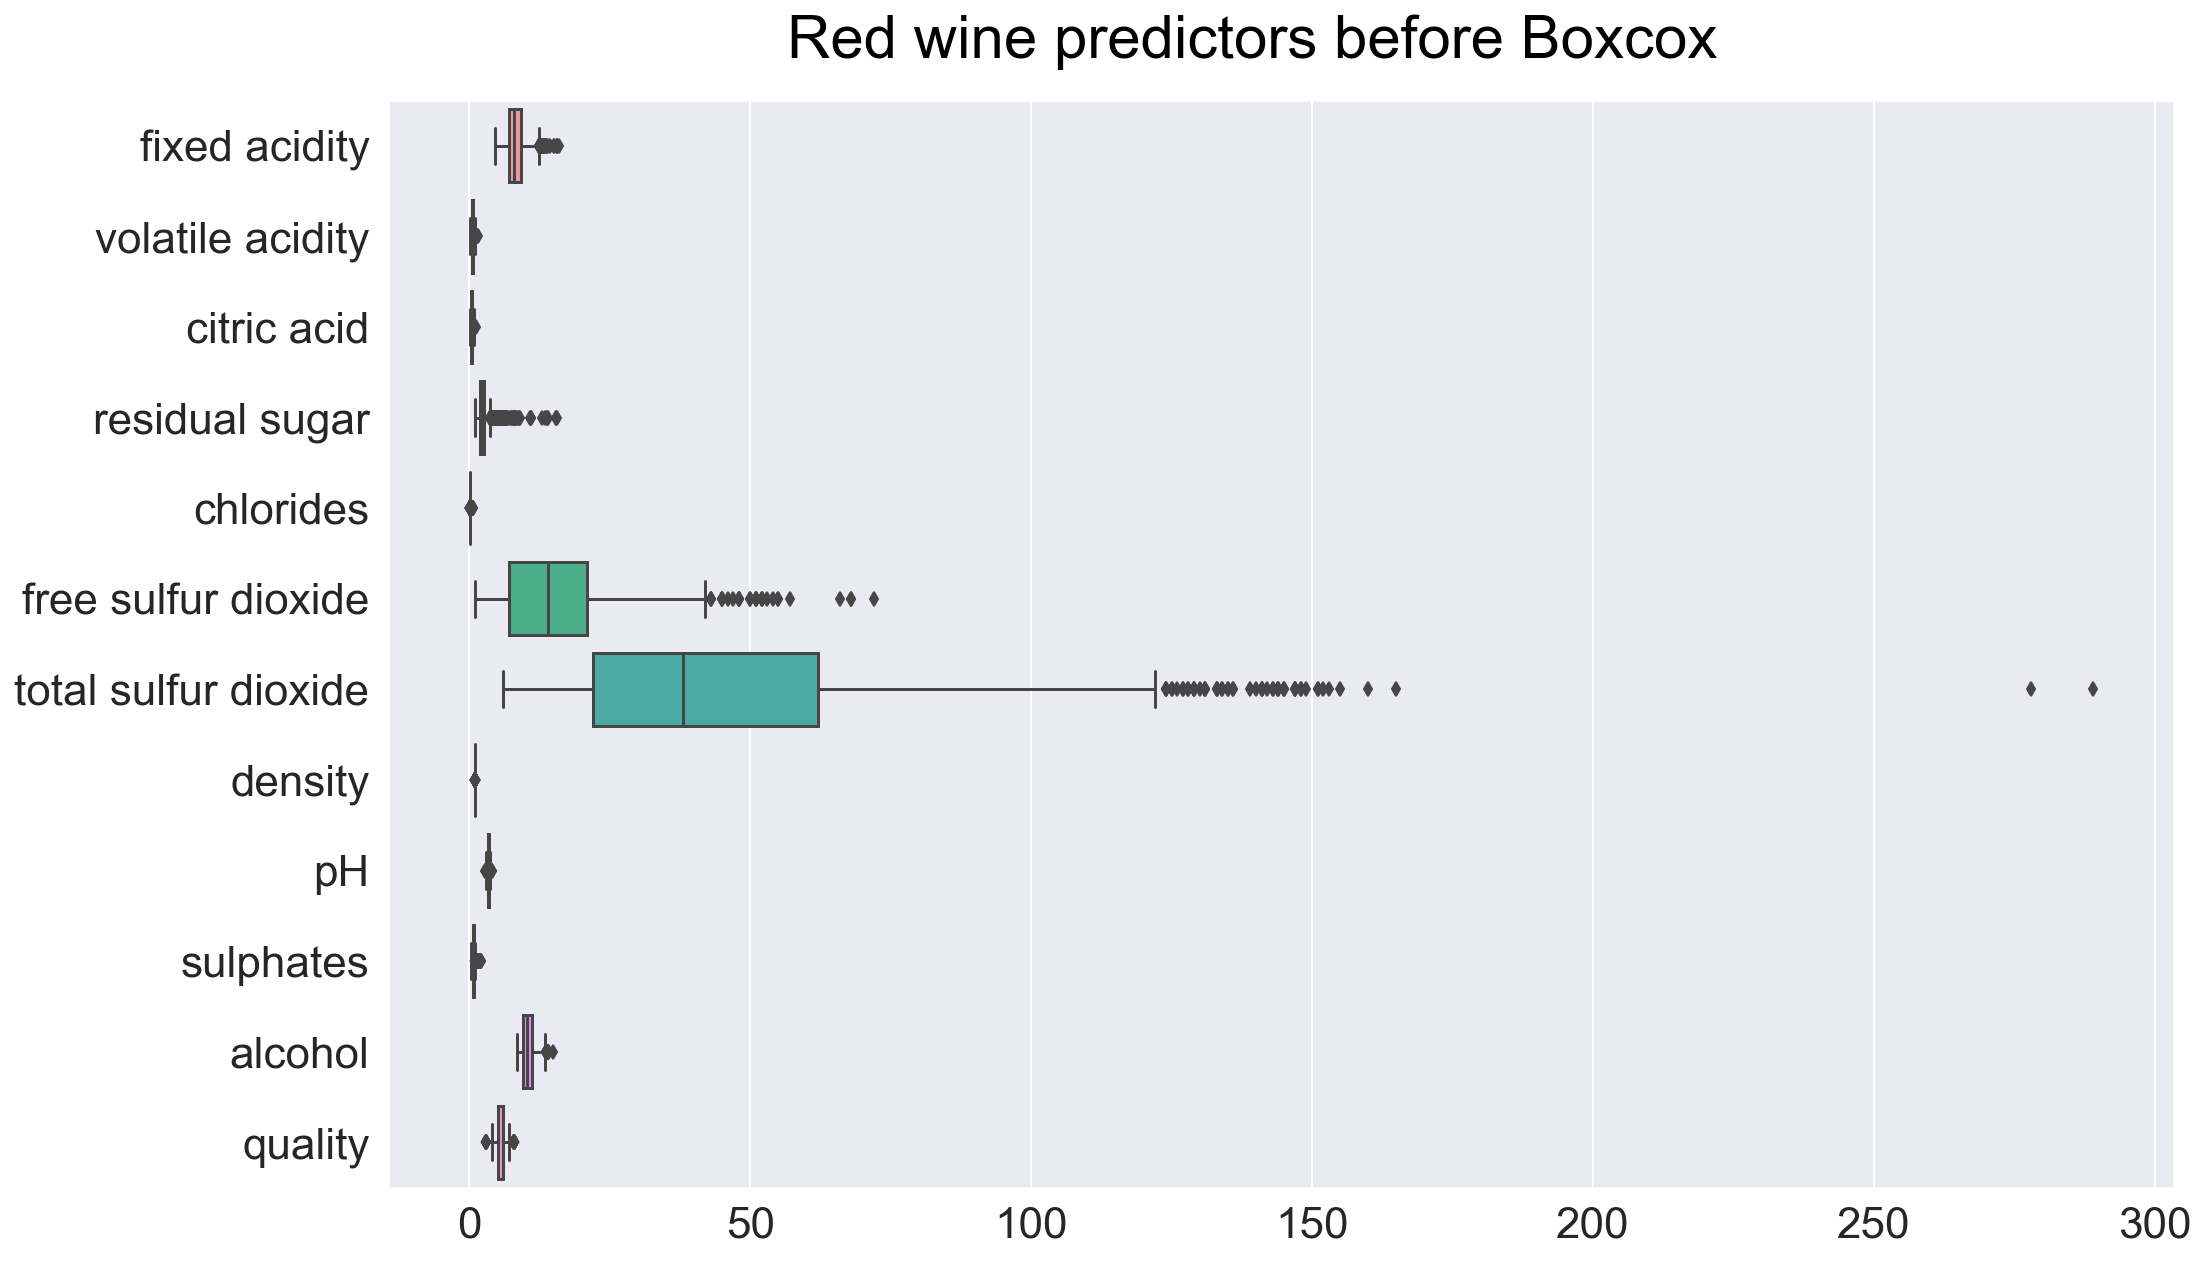

In [50]:
# Custom boxplot
def box_plot(data, height = 10, width = 16, title = "Boxplot"):
    # Make the figure object
    plt.figure(figsize=(width, height))
    # Add title
    plt.suptitle(title, y = 0.94, fontsize = 30)
    # Scale the font size
    sns.set(font_scale = 2)
    # Create the boxplot
    sns.boxplot(data = data, orient = "h")
    
box_plot(data = wine_red_df, title = "Red wine predictors before Boxcox")

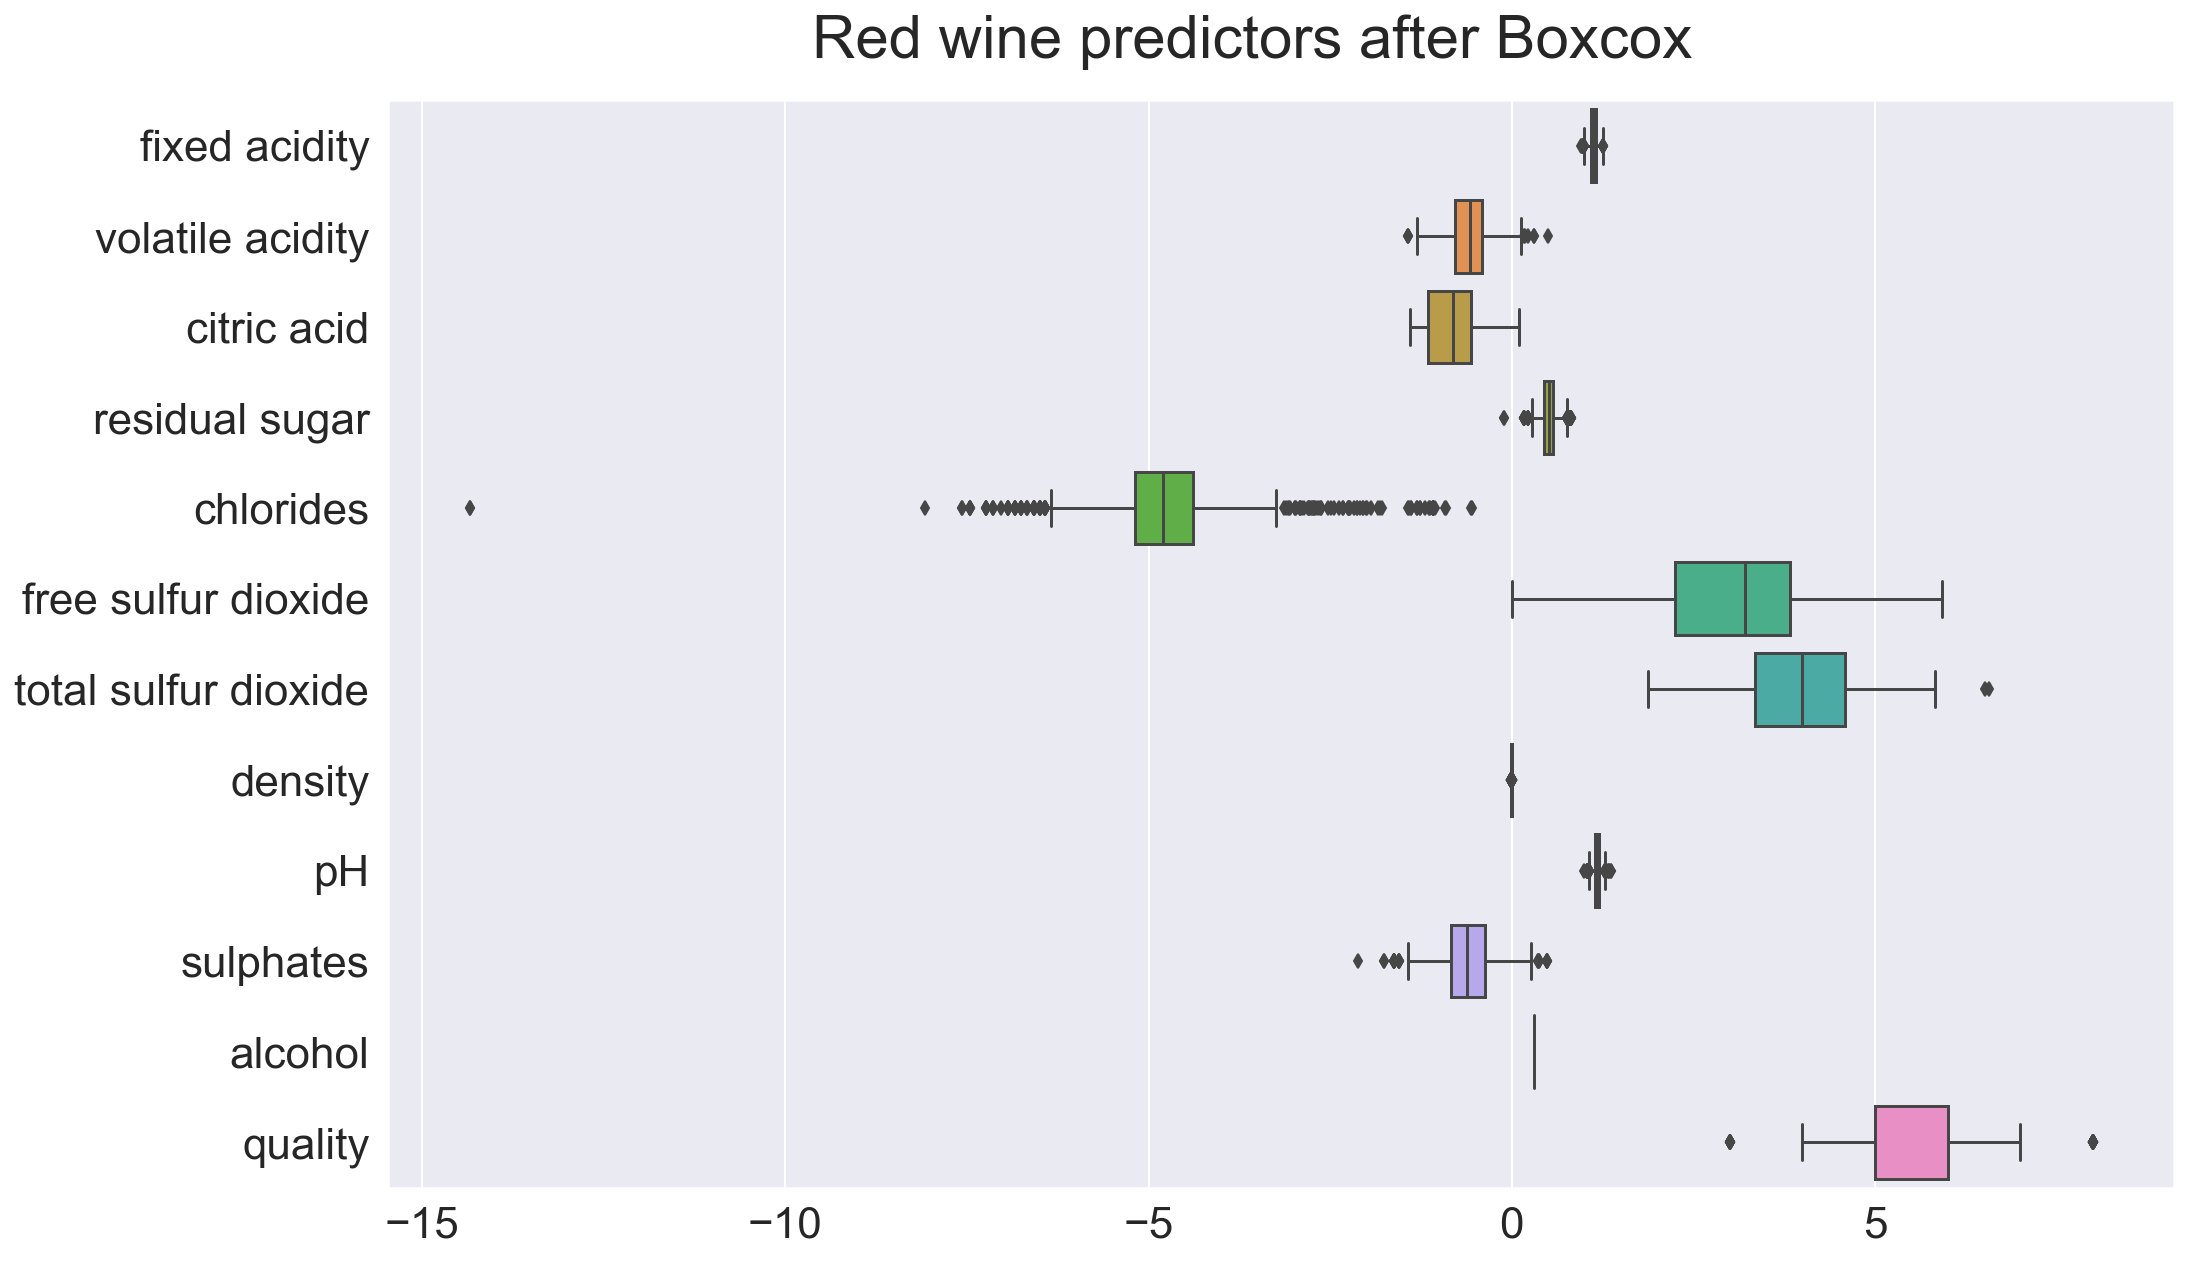

In [51]:
box_plot(data = red_trans, title = "Red wine predictors after Boxcox")

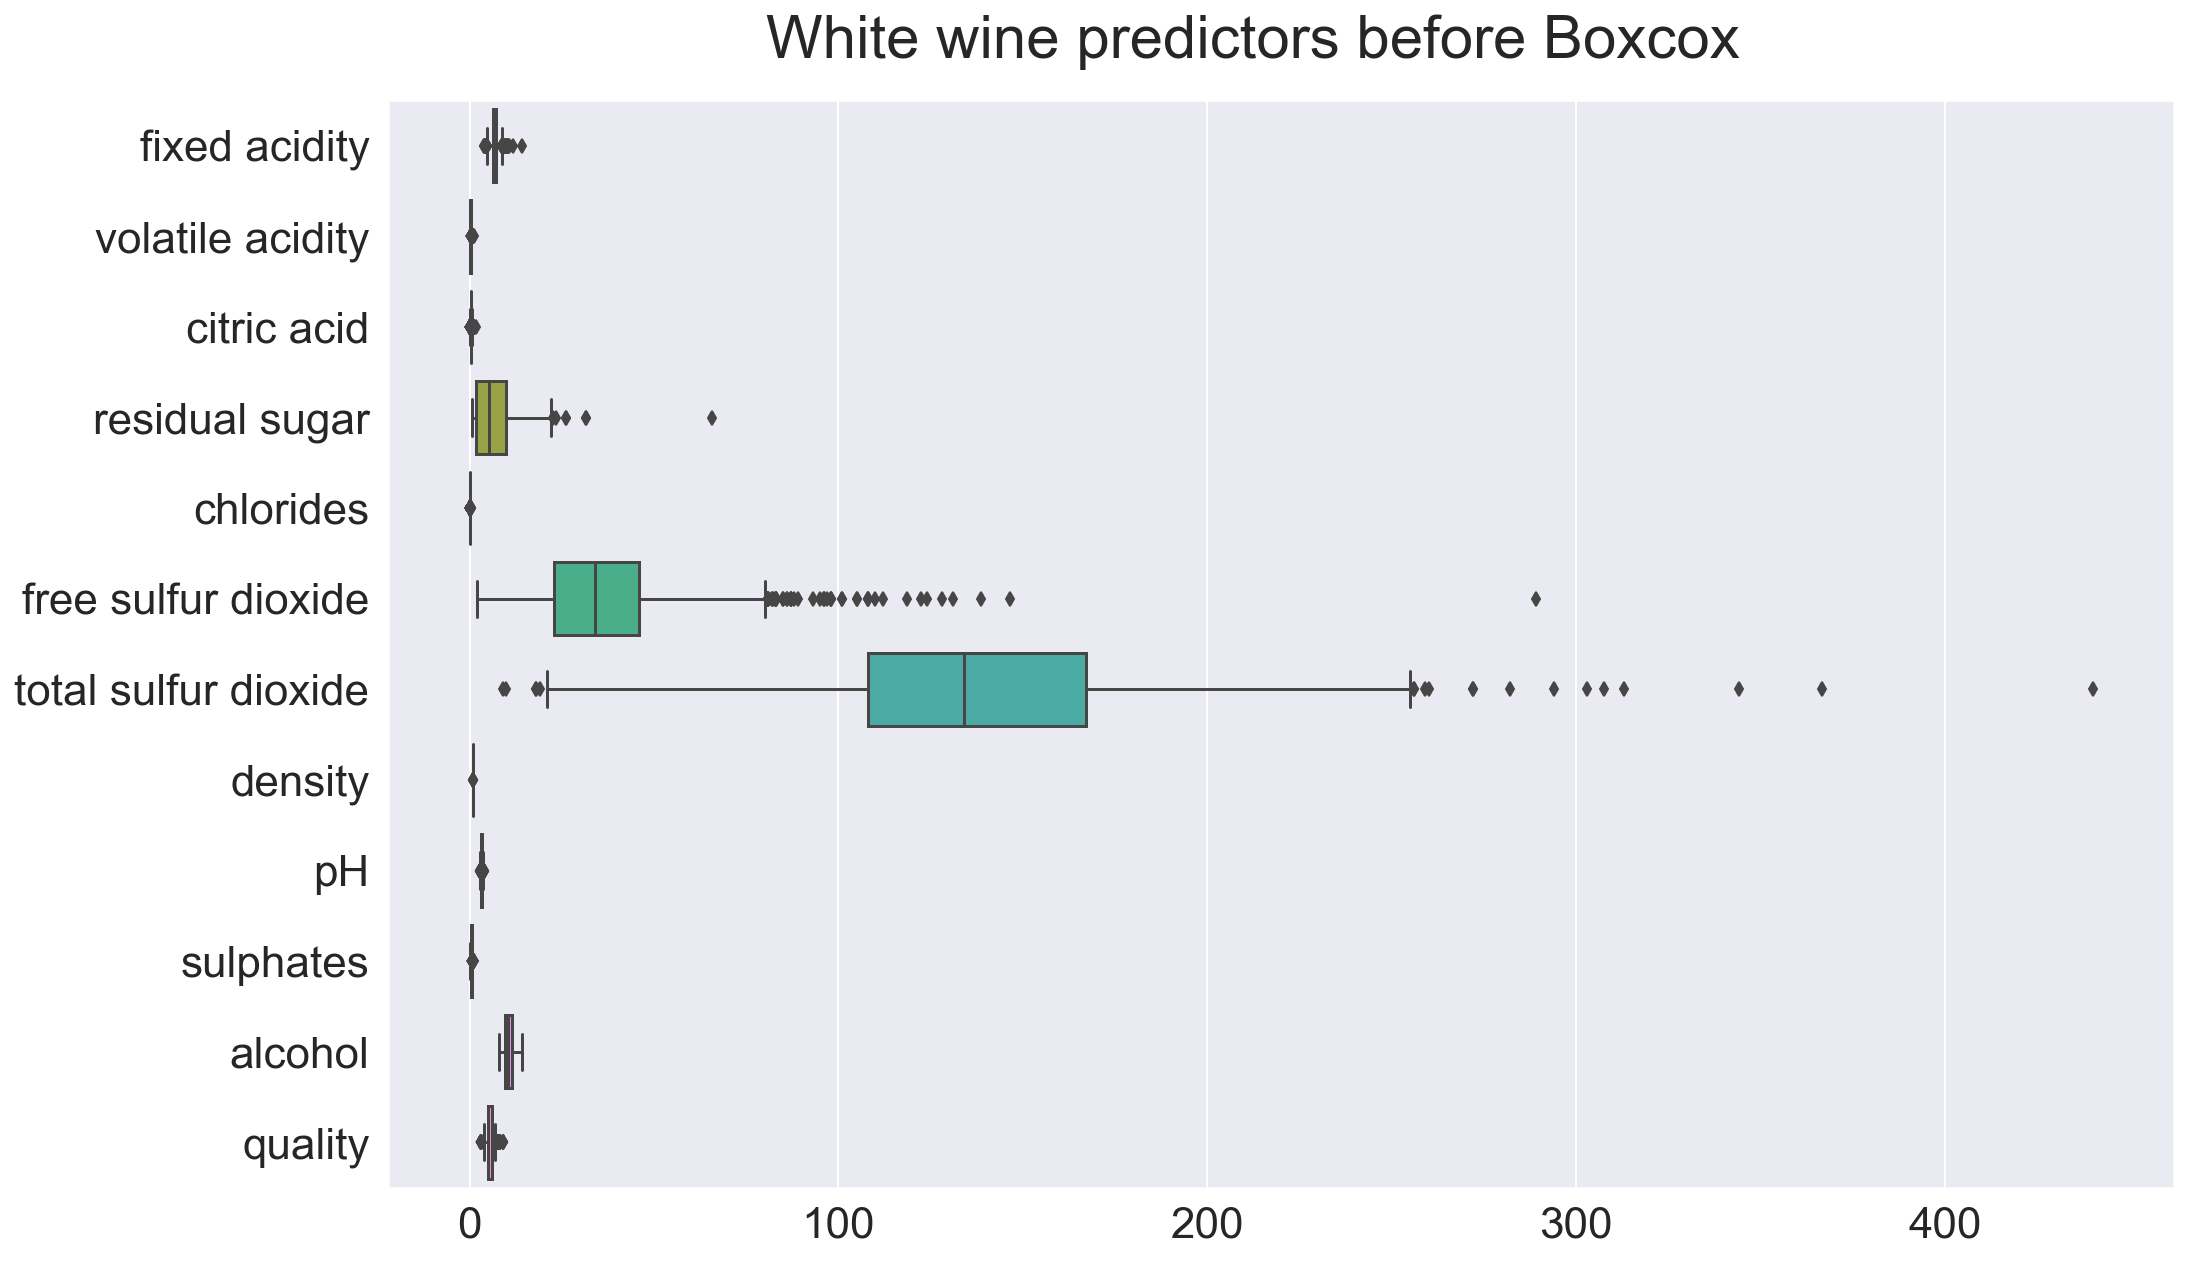

In [52]:
box_plot(data = wine_white_df, title = "White wine predictors before Boxcox")

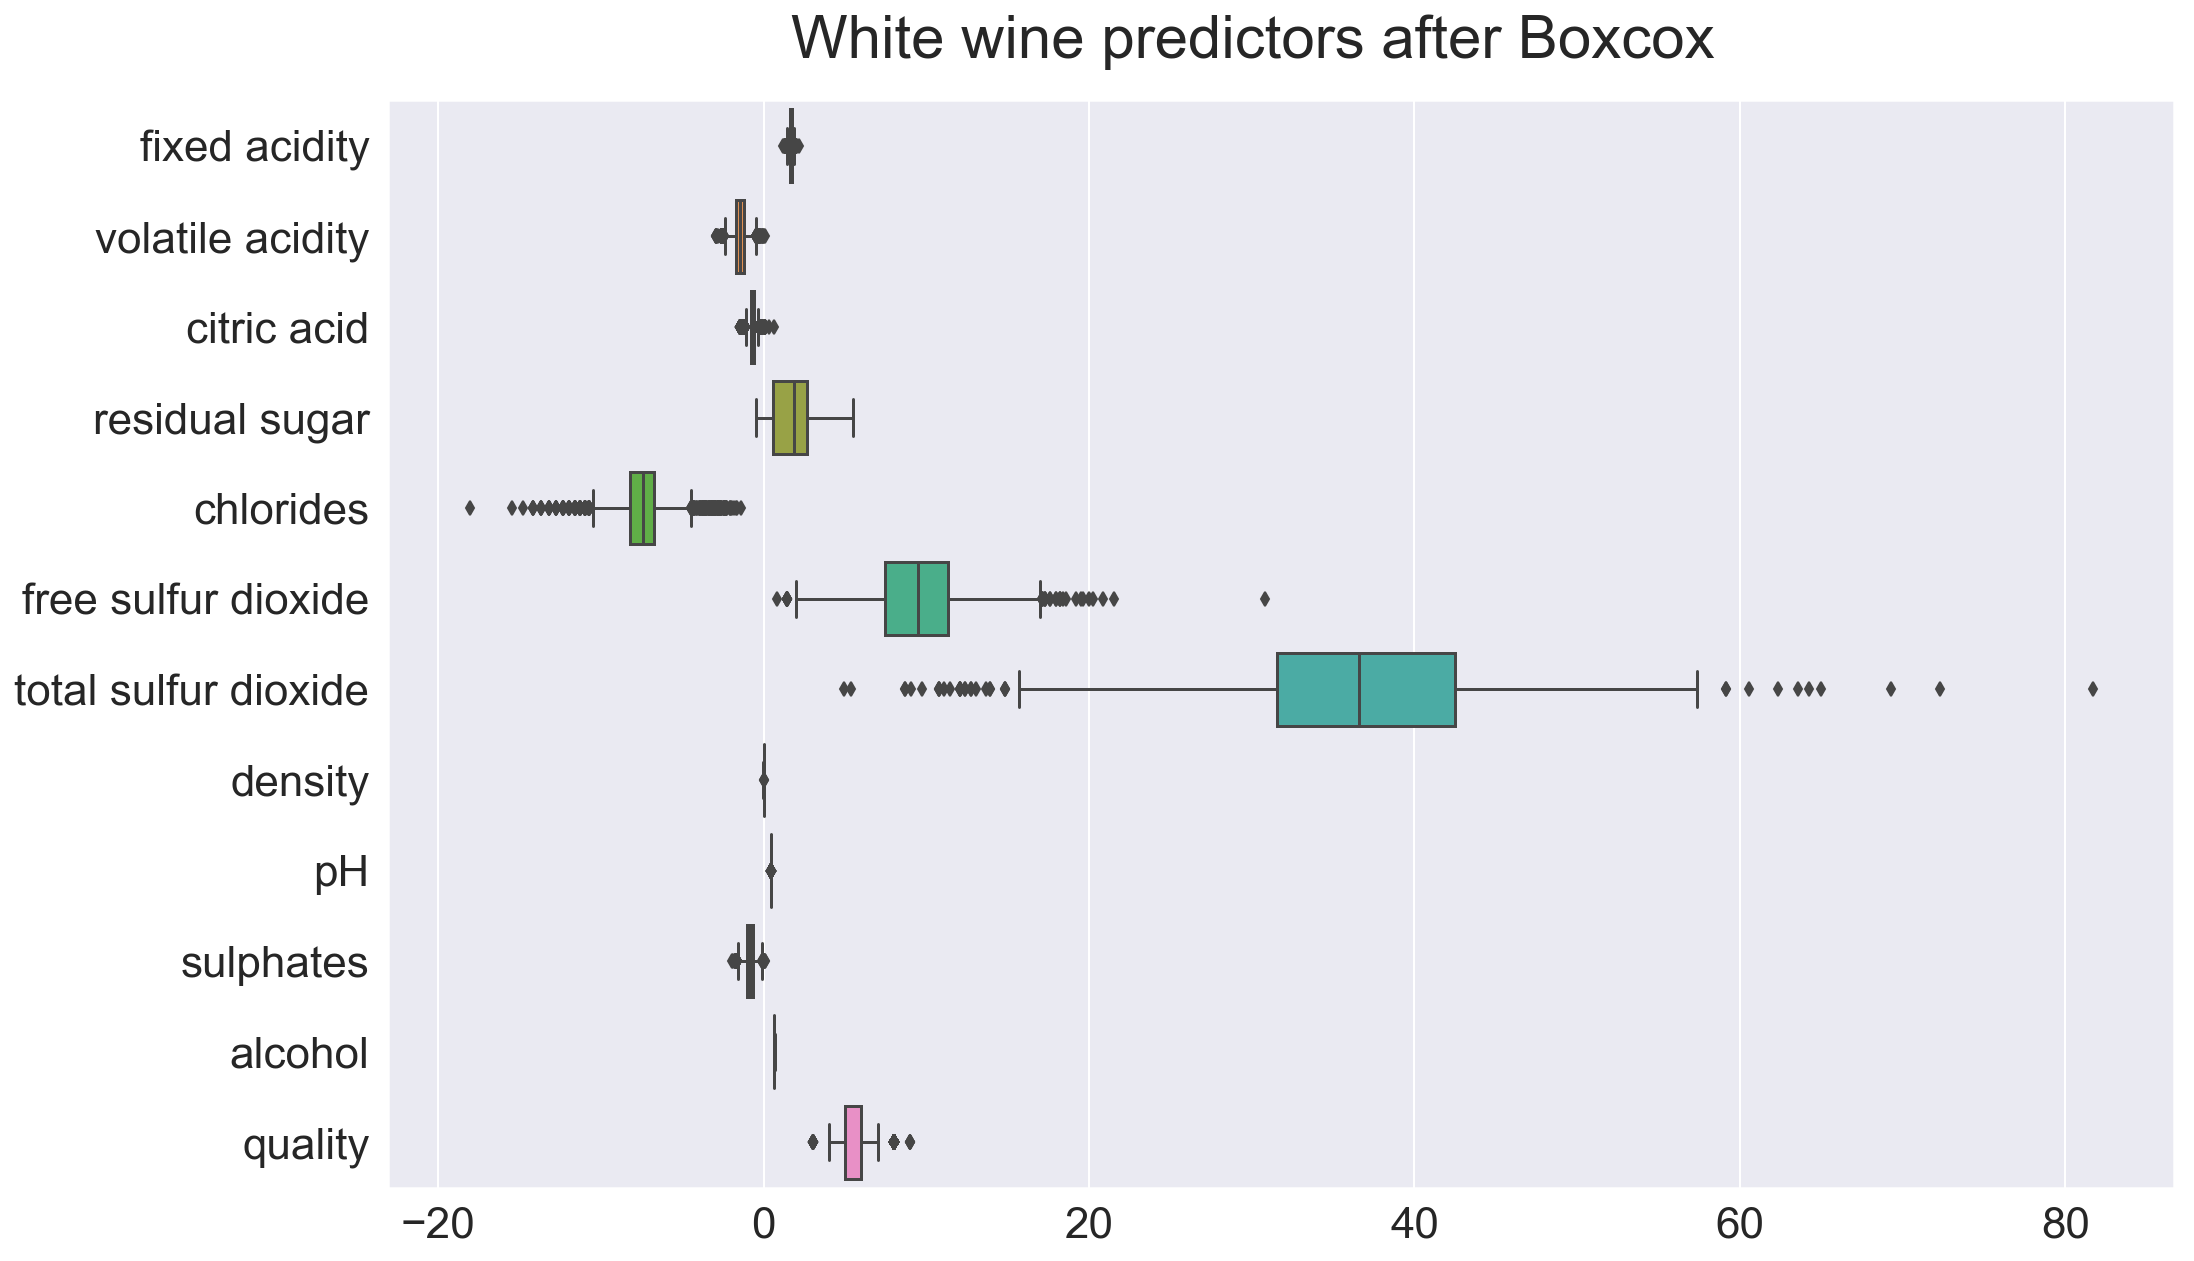

In [53]:
box_plot(data = white_trans, title = "White wine predictors after Boxcox")

We can clearly see that we were able to scale the predictors and at the same time remove some outliers from the data.

Machine Learning

Now that we have did our analysis on the data and done with all the preprocessing, let try to bulid our mndel that could predict quality of the red and white wine. The quality is dicrete label attribute, so this is a supervised classification problem.

We will two approach for buliding model. One is using one of the traditional classifcation Machine Learning algorithm and another by using Neural Networks using Tensorflow. For the traditional model I am going to use Support vector Machines. Thus we have

    Support Vector Machines
    Neural Networks

Before creating the model we need to split the data into testing and training set. This will help us to make our more generalized to the data which we have not seen before. We will have 75% of the data in the train set and the rest in the test set. I have set the randomw seed to be 1 for reproduciablity

In [54]:
# Split the the whole data into test and train
X_train_red, X_test_red, y_train_red, y_test_red = train_test_split(wine_red_df.iloc[:, :-1], wine_red_df.iloc[:, -1],
                                                    test_size=0.25, random_state=1)
X_train_white, X_test_white, y_train_white, y_test_white = train_test_split(wine_white_df.iloc[:, :-1], wine_white_df.iloc[:, -1],
                                                    test_size=0.25, random_state=1)

Support Vector Machines (SVM)

SVM is a supervised machine learning algorithm which can be used for both classification or regression problems. But it's usually used for classification. Given 2 or more labeled classes of data, it acts as a discriminative classifier, formally defined by an optimal hyperplane that seperates all the classes. New examples that are then mapped into that same space can then be categorized based on on which side of the gap they fall.

In [55]:
# Custom functions to use the SvM model
def svm_accuracy_cv(X_train, X_test, y_train, y_test, n_fold = 10):
    # Intialize the variables
    best_score = 0
    best_C = 10000
    C_list = [1, 10, 100, 1000]
    for C in C_list:
        # Creating the SVM model 
        svc = svm.SVC(C = C, kernel = 'rbf')
        # Getting the scores on n folds
        scores = cross_val_score(svc, X_train, y_train, cv = n_fold)
        score = scores.mean()
        # Check and assign the best score paramters
        if score > best_score:
            best_C = C
            best_score = score
    # Fir the complete model over all the training data
    svc = svm.SVC(C = best_C, kernel = "rbf")
    svc.fit(X_train, y_train)
    # Get the accuracy over the teating data
    accuracy = svc.score(X_test, y_test)
    return accuracy, best_C

# Compute the accuracy
red_wine_accuracy, C_red = svm_accuracy_cv(X_train_red, X_test_red, y_train_red, y_test_red, n_fold = 10)
white_wine_accuracy, C_white = svm_accuracy_cv(X_train_white, X_test_white, y_train_white, y_test_white, n_fold = 10)

# Print the accuracy
print("The accuracy of the SVM model on Red wine dataset with 10 fold cross validation is", 
      round(red_wine_accuracy * 100, 2), "percentage with the best cost value of", C_red)
print("The accuracy of the SVM model on White wine dataset with 10 fold cross validation is", 
      round(white_wine_accuracy * 100, 2), "percentage with the best cost value of", C_white)

The accuracy of the SVM model on Red wine dataset with 10 fold cross validation is 57.75 percentage with the best cost value of 1000
The accuracy of the SVM model on White wine dataset with 10 fold cross validation is 57.55 percentage with the best cost value of 1000


Now we have the model for predicting the quality scale of the red and white wine seperately. Can we bulid a model that can make predicition on whether it is a red or white wine? Of course we can, let also bulid that model. For this we need to merge both the dataset into one single dataset by haveing new column that represent '0' for Red and '1' white wine. Then we will follow the same procedure as previously to use the custom SVM model we bulid before.

In [56]:
# Adding the new column wine type 
red_trans["wine type"] = 0
white_trans["wine type"] = 1

# Concatenate both the dataset
wine_df = pd.concat([red_trans, white_trans], axis = 0, ignore_index = False)

# Split the the whole data into test and train
X_train, X_test, y_train, y_test = train_test_split(wine_df.iloc[:, :-1], wine_df.iloc[:, -1],
                                                    test_size=0.25, random_state=1)

# Compute the accuracy
accuracy, C = svm_accuracy_cv(X_train, X_test, y_train, y_test, n_fold = 10)

# Print the accuracy
print("The accuracy of the SVM model on Red wine dataset with 10 fold cross validation is", 
      round(accuracy * 100, 2), "percentage with the best cost value of", C_red)

The accuracy of the SVM model on Red wine dataset with 10 fold cross validation is 100.0 percentage with the best cost value of 1000


And this is amazing !!! We have 100% accurate model that we can implement in the production environment to classify any new data points as whether it is a red or white wine.

Neural Networks with Tensorflow

Now that we have completed buliding the classifier model using Support Vector Machines let us bulid the neural network model that could classify whether a wine is red or white wine. We will bulid the neural network using package called Tensorflow. TensorFlow is an open-source software library for machine learning across a range of tasks. It is a symbolic math library, and also used as a system for building and training neural networks to detect and decipher patterns and correlations, analogous to human learning and reasoning.

In order to work on this I am going to bulid a NeuralNet class using tensorflow. Buliding class helps us such that we get to have all the advantage of Object Oriented Programming.

This is a binary classfier with which we will try to bulid a neural net that could classify the wine type. Lets get started!

In [57]:
class NeuralNet:
    
    # initalize the class variables
    def __init__(self, learning_rate = 0.001, batch_size = 100, epochs = 1000):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
    
    # One hot encoding of the labels
    def dense_to_one_hot(self, labels_dense, num_classes = 2):
        # Intialize the output variable
        labels_one_hot = []
        # Frame the label array
        for label in labels_dense:
            indices = [1]*num_classes
            indices[label] = 0
            labels_one_hot.append(indices)
        return labels_one_hot

    # Create batches of the training set
    def make_batch(self, X, y, batch_size):
        # Compute the length of the data
        y_size = len(y)
        # Create random batches
        index_sample = np.random.choice(X.shape[0], batch_size, replace=False)
        y_array = np.array(y)
        # Subset by the index
        X_batch = X[index_sample, :]
        y_batch = y_array[index_sample]
        return X_batch, y_batch
    
    # Computes the soft max layer
    def softmax_layer(self, X_tensor, num_units):
        # Get the size of the input from the tensor
        num_inputs = X_tensor.get_shape()[1].value
        # Create weight, bias and label variables
        W = tf.Variable(tf.zeros([num_inputs, num_units]), name='W')
        b = tf.Variable(tf.zeros([num_units]), name='b')
        # Compute out y on the this layer
        y = tf.nn.softmax(tf.matmul(X_tensor, W) + b)
        return y
    
    # Computes the Rectified Linear Units
    def relu_layer(self, X_tensor, num_units):
        # Get the size of the input from the tensor
        num_inputs = X_tensor.get_shape()[1].value
        # Create weight, bias and label variables
        W = tf.Variable(tf.random_uniform([num_features, num_units]), name='W')
        b = tf.Variable(tf.zeros([num_units]), name='b')
        # Compute the rectified linear unit activation on this point
        y = tf.nn.relu(tf.matmul(X_tensor, W) + b, name='relu')
        return y
    
    # Compute teh cost function
    def define_cost_function(self, y, y_tensor, batch_size):
        # Define the cross entropy cost
        cost = -tf.reduce_sum(y_tensor * tf.log(y), name='cross_entropy') / batch_size
        return cost
    
    # Train the model
    def train(self, cost, learning_rate):
        # Use Gradient descent to compute the optimum
        training_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
        return training_step
    
    # Formulates the accuracy
    def compute_accuracy(self, y, y_tensor):
        # Check the predictions
        correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_tensor, 1))
        # Compute the accuracy
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"), name='accuracy')
        return accuracy
    
    # bulid the two layer Net
    def two_layers(self):
        # Create hidden, relu layer
        with tf.name_scope("hidden_layer") as scope:
            y_relu = self.relu_layer(X_placeholder, hidden_layer_units)

        # Create softmax layer
        with tf.name_scope("softmax") as scope:
            y_softmax = self.softmax_layer(y_relu, num_classes)

        # Define cost function
        with tf.name_scope("cost_function") as scope:
            global cost
            cost = self.define_cost_function(y_softmax, y_placeholder, batch_size)
            tf.summary.scalar("cost", cost)

        # Define training step
        with tf.name_scope("training") as scope:
            global training_step
            training_step = self.train(cost, learning_rate)

        # Calculate model accuracy
        with tf.name_scope("accuracy") as scope:
            global accuracy
            accuracy = self.compute_accuracy(y_softmax, y_placeholder)
            tf.summary.scalar("accuracy", accuracy)

In [99]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

W0831 20:41:56.422348 10748 deprecation.py:323] From C:\Users\ashukla\Anaconda3\lib\site-packages\tensorflow\python\compat\v2_compat.py:63: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
Instructions for updating:
non-resource variables are not supported in the long term


In [100]:
# Hyperparamters
learning_rate = 0.001
batch_size = X_train.shape[0] // 10
num_features = X_train.shape[1]
num_classes = 2
epochs = 1000
epoch_list = []
epochs_to_print = epochs // 10
hidden_layer_units = 30
avg_cost_list = []

# Define the placeholder
X_placeholder = tf.placeholder(tf.float32, [None, num_features], name='X')
y_placeholder = tf.placeholder(tf.float32, [None, num_classes], name='y')

# Create the NeuralNet Class object
NN = NeuralNet()

# Do one hot encoding for the labels
y_train_one_hot = NN.dense_to_one_hot(y_train, num_classes = num_classes)
y_test_one_hot = NN.dense_to_one_hot(y_test, num_classes = num_classes)

# Call the layers 
NN.two_layers()

# Merge summaries for TensorBoard
merged_summaries = tf.summary.merge_all()

# Start the tensorflow session
with tf.Session() as sess:
    # Create the log directory
    log_directory = 'tmp/logs'
    summary_writer = tf.summary.FileWriter(log_directory, sess.graph)
    
    # Intialize the global variables
    tf.global_variables_initializer().run()
    
    cost_sum = 0
    for i in range(epochs):
        # Make the batches
        X_batch, y_batch = NN.make_batch(np.array(X_train), np.array(y_train_one_hot), batch_size)
        # Feeder
        feed_dict = {X_placeholder: X_batch, y_placeholder: y_batch}
        # Compute the cost
        _, current_cost = sess.run([training_step, cost], feed_dict)
        # Sum the overall cost
        cost_sum += current_cost
        
        # Print average cost periodically
        if i % epochs_to_print == 99:
            average_cost = cost_sum / epochs_to_print
            avg_cost_list.append(round(average_cost, 4))
            epoch_list.append(i+1)
            print("Epoch: {:4d}, average cost = {:0.3f}".format(i+1, average_cost))
            cost_sum = 0
    
    print('\nFinished model fitting.')
 
    # Calculate final accuracy
    X_batch, y_batch = NN.make_batch(np.array(X_test), np.array(y_test_one_hot), batch_size)
    feed_dict = {X_placeholder: X_test, y_placeholder: y_test_one_hot}
    print("\nFinal accuracy = {:0.3f}%".format(sess.run(accuracy * 100, feed_dict)))
    

# Custom style attribute function
# Best practive for bokeh users
def custom_analysis_line_plot(data, x_col, y_col, title, width = 800, height = 600, xlab = "X-axis", ylab = "Y-axis", 
                         line_width = 4):
    # Creating the variables for the color prop
    color = d3['Category20b'][17][2]
    # Create the figure object
    p = figure(width = width, height = height, title = title, x_axis_label = xlab, y_axis_label = ylab)
    # Provide the attribute for the line()
    p.line(data.iloc[:, x_col], data.iloc[:, y_col], color = color, line_width = line_width)
    # Add plot style attributes
    p.title.text_font_size = "20pt"
    p.title.align = "center"
    p.xaxis.axis_label_text_font_size = "20pt"
    p.yaxis.axis_label_text_font_size = "20pt"
    return show(p)

# Create the data 
cost_df = pd.DataFrame({'Epoch': epoch_list, 'Cost': avg_cost_list})
# Show the plot
custom_analysis_line_plot(data = cost_df, x_col = 1, y_col = 0, title = "Epochs vs Cost", 
                     width = 800, height = 600, xlab = "Epochs", ylab = "Cost", line_width = 4)

Epoch:  100, average cost = 0.199
Epoch:  200, average cost = 0.090
Epoch:  300, average cost = 0.060
Epoch:  400, average cost = 0.046
Epoch:  500, average cost = 0.037
Epoch:  600, average cost = 0.032
Epoch:  700, average cost = 0.027
Epoch:  800, average cost = 0.025
Epoch:  900, average cost = 0.022
Epoch: 1000, average cost = 0.020

Finished model fitting.

Final accuracy = 99.754%


Thus the Neural network with tensorflow has got the accuracy of the 99.754%

We also can understand one more thing from this. That is if you look back our SVM model provided an accuracy of 100% where as Neural Networks being praised as superior Machine Learning alo=gorithm nowadays have got 0.25 less on the SVM results. This shows that in general machine learning world it more better to try the simpler ones at first before heading you way to harded problem.
